In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import itertools
import statsmodels.api as sm
import networkx as nx
import seaborn as sns
import pandas as pd

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx

from tqdm import tqdm

In [86]:
def SCM_learner(spike_data, node_list, stimulation_protocol, alpha=0.01):
    """
    spike_data: dictionary of observed neuron data sets, where the key is the intervention used. 'null' is no intervetion. 
    '1' means node 1 was intervened on, '123' means node 1, 2 and 3 were intervened on, etc.
    node_list: a list contining node names of the observed variables
    stimulation_protocol: list of indeces for intervened neurons at each intervention.
    """
    SCM_learned = nx.DiGraph()
    SCM_learned.add_nodes_from(np.sort(node_list))

    # observational data
    spikes = spike_data['null']
    
    #stimulation_protocol_str = [''.join(str(i) for i in intervention_set) for intervention_set in stimulation_protocol]
        
    # loop through nodes in network, to test what other notes can explain spiking using a linear model
    for idx, neuron_id in enumerate(node_list):
        
        target_spikes = spikes[idx].numpy()
        
        source_spikes = np.delete(torch.roll(spikes, 1), idx, axis=0) # effect from 1 time step before
        #source_spikes2 = np.delete(torch.roll(spikes, 2), idx, axis=0) # effect from 2 time step before
        autoregressive_feature1 = torch.roll(spikes[idx], 1).numpy() # 1 time step history effects
        autoregressive_feature2 = torch.roll(spikes[idx], 2).numpy() # 2 time step history effects
        autoregressive_feature3 = torch.roll(spikes[idx], 3).numpy() # 3 time step history effects

        # create design matrix
        X = np.vstack((source_spikes, autoregressive_feature1, autoregressive_feature2))

        # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
        linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
        res = linear_model.fit()

        source_nodes = np.delete(node_list, idx) # remove target neuron
        p_values = res.pvalues[1:len(node_list)] # p-values of t-test of effect from source to targat neuron (first time step coefficient)
        
        #print(p_values)
        
        for k, p in enumerate(p_values):
            if p < alpha:
                SCM_learned.add_edge(source_nodes[k], neuron_id)
    
    # Adjacency matrix based on observational data
    A_learned = nx.adjacency_matrix(SCM_learned).todense() 
    SCM_observational = SCM_learned.copy()

    # loop through each intervention set to remove confounding effects
    for intervention_set in stimulation_protocol:
        intervention_set_str = ''.join(str(x) for x in intervention_set)        
        spikes = spike_data[intervention_set_str] # get data set where the given intervention occurred

        for intervened_neuron in intervention_set:            
            intervened_neuron_idx = node_list.index(intervened_neuron)

            # get indeces of neurons that intervened node is correlated with
            target_idx = np.where(A_learned[intervened_neuron_idx, :] == 1) 
            #target_neurons = node_list[target_idx[0]]
            target_neurons = [v for _, v in SCM_observational.out_edges(intervened_neuron)]

            if len(target_neurons) == 0:
                continue

            else:
                # loop through the neurons that the intervened node is observationally correlated with
                for target_neuron in target_neurons:
                    target_neuron_idx = node_list.index(target_neuron)

                    sources_idx = np.where(A_learned[:, target_neuron_idx] == 1) # possible explanations for target neuron
                    #source_neurons = index_obs[sources_idx[0]]
                    source_neurons = [u for u, _ in SCM_observational.in_edges(target_neuron)]

                    intervened_idx = np.where(source_neurons == intervened_neuron)[0]
                    target_spikes = spikes[target_neuron_idx].numpy()

                    source_spikes = torch.roll(spikes[sources_idx[0]], 1).numpy() # effect from 1 time step before
                    #source_spikes2 = torch.roll(spikes[sources_idx[0]], 2).numpy() # effect from 2 time step before
                    autoregressive_feature1 = torch.roll(spikes[target_neuron_idx], 1).numpy() # 1 time step history effects
                    autoregressive_feature2 = torch.roll(spikes[target_neuron_idx], 2).numpy() # 2 time step history effects

                    # create design matrix
                    X = np.vstack((source_spikes, autoregressive_feature1, autoregressive_feature2))

                    # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
                    linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
                    res = linear_model.fit()
                    #print(res.pvalues)
                    p_values = res.pvalues[intervened_idx+1] # p-values of t-test of effect from source to targat neuron (first time step coefficient)
                    #
                    #print('p_values = ',p_values)
                    #print(res.pvalues)
                    if np.any(p_values > alpha):
                        #print(f'removed edge ({intervened_neuron}, {target_neuron})')
                        SCM_learned.remove_edge(intervened_neuron, target_neuron)

    return SCM_learned

In [9]:
example_network = torch.load('data/c_elegans_data.pt')

In [10]:
# model parameters
theta = 3

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=theta,
    dt=1.,
    coupling_window=1,
    abs_ref_scale=3,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [100]:
n_neurons = example_network.num_nodes
n_obs = 50
n_hidden = n_neurons - n_obs

G = to_networkx(example_network, node_attrs = ['position'])
position_dict = nx.get_node_attributes(G, 'position')
sample_space = []
for neuron in position_dict:
    if position_dict[neuron] < 0.15:
        sample_space.append(neuron)

index_obs = np.sort(np.random.choice(sample_space, size = n_obs, replace = False))
#index_obs = np.sort(sample_space)
#print(sample_space)
print(index_obs)
print('n_obs = ', n_obs)
print('n_edges = ', example_network.num_edges)
print('n_neurons = ', example_network.num_nodes)

[  2   7  10  15  16  20  22  27  36  44  50  53  56  59  99 103 109 111
 128 138 140 149 155 156 158 161 163 165 167 176 184 185 186 196 197 203
 206 209 213 224 227 229 233 243 244 252 255 259 262 268]
n_obs =  50
n_edges =  2194
n_neurons =  279


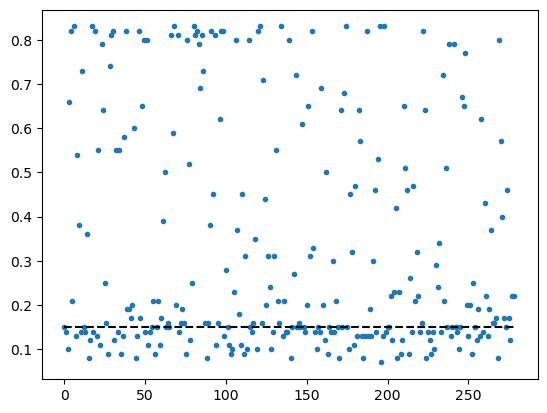

In [101]:
plt.scatter(np.arange(n_neurons), position_dict.values(), marker='.')
plt.hlines(y=0.15, xmin=0, xmax=n_neurons, linestyles='dashed', colors='black')

In [102]:
G_obs = nx.subgraph(G, index_obs)

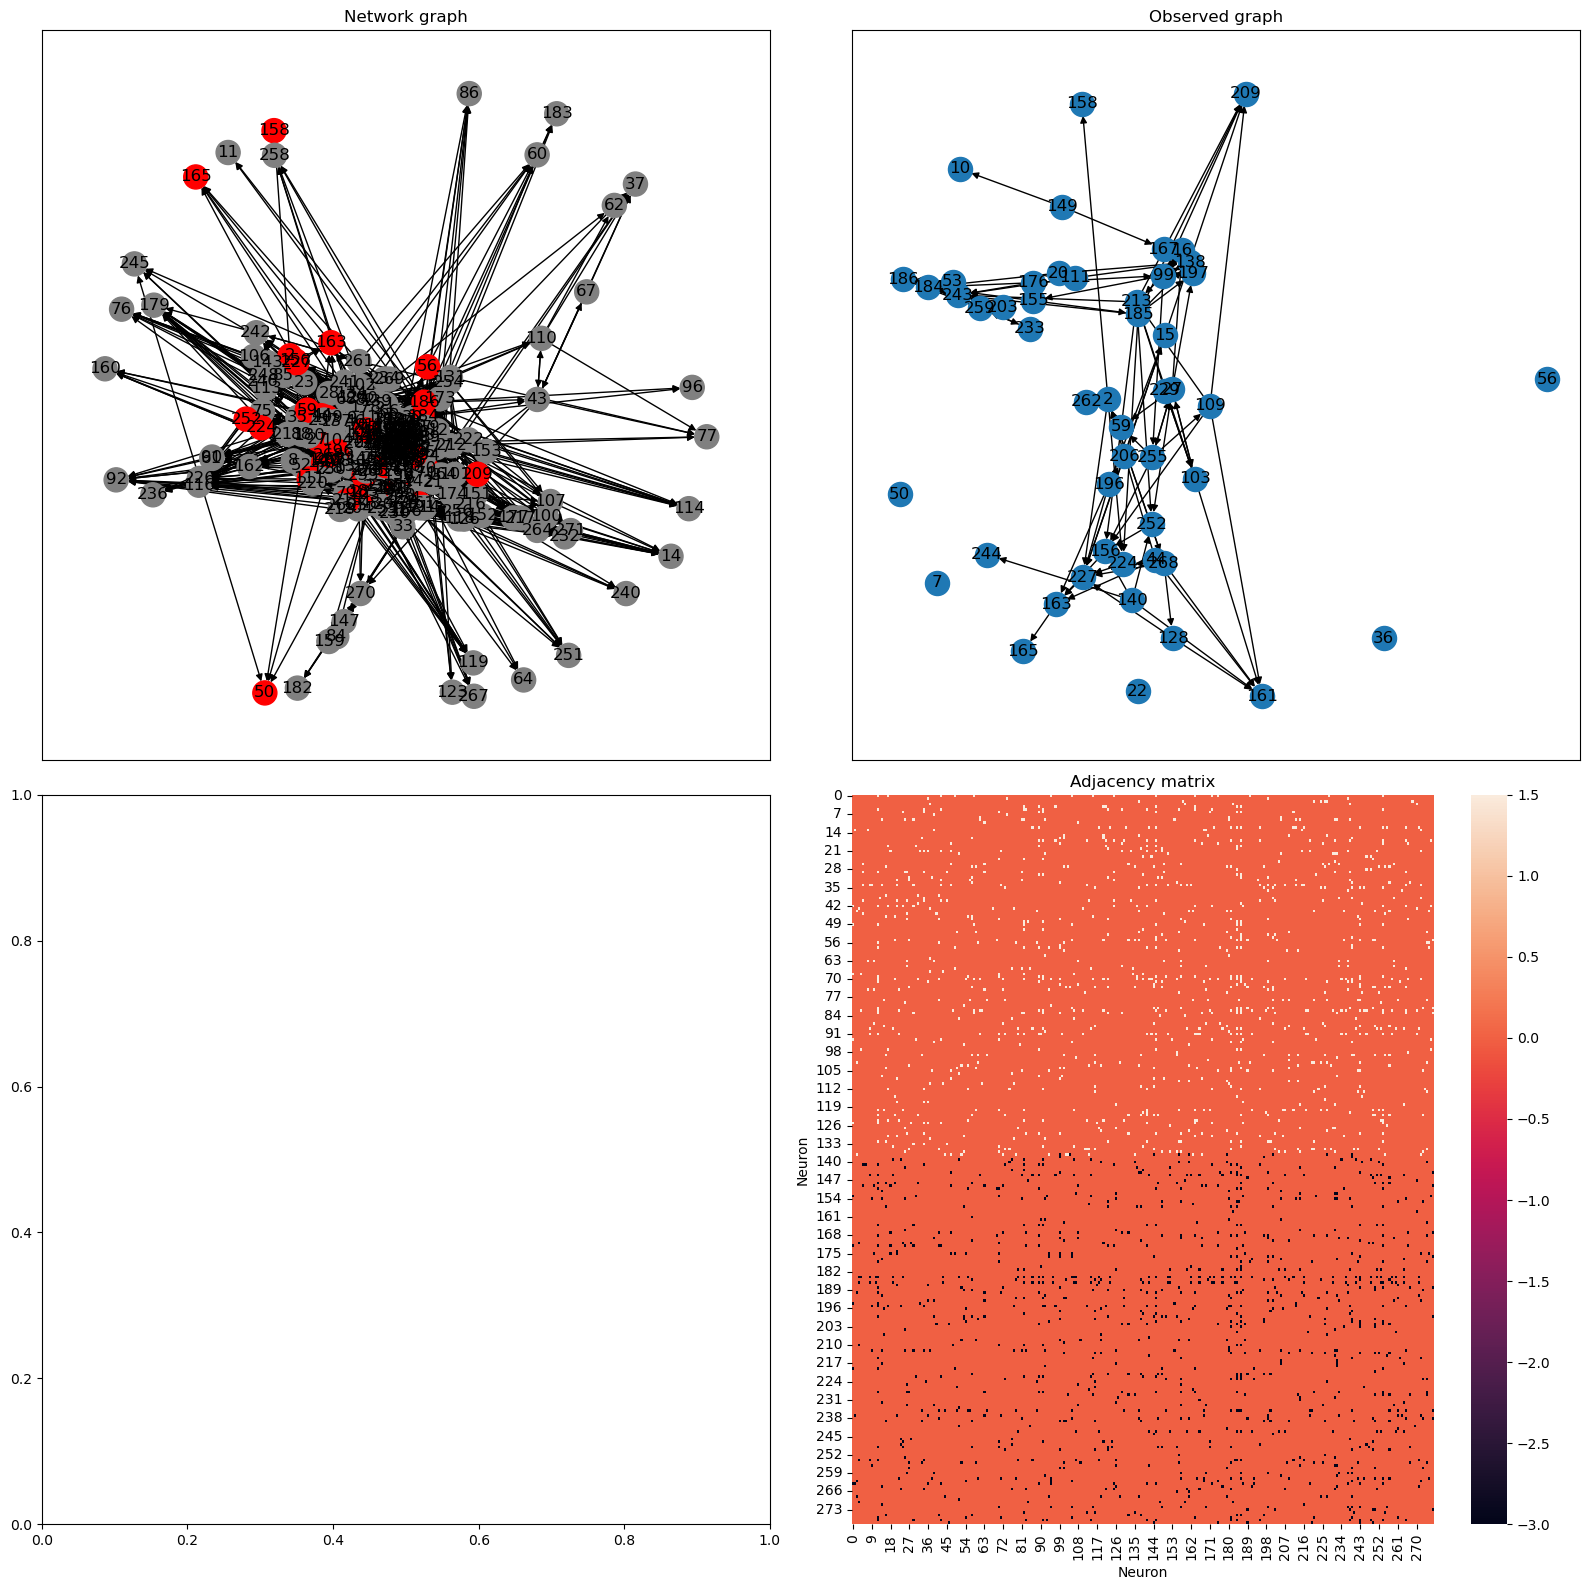

In [103]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
color_map = ['grey' if node not in index_obs else 'red' for node in G]        

nx.draw_networkx(G, arrows=True, ax=ax[0,0], node_color=color_map)
ax[0,0].set_title("Network graph")

nx.draw_networkx(G_obs, arrows=True, ax=ax[0,1])
ax[0,1].set_title("Observed graph")

W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1,1], annot=False)
ax[1,1].set_title("Adjacency matrix")
ax[1,1].set_xlabel("Neuron")
ax[1,1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

In [104]:
prop_intervened = 1.0

spike_data = []
spike_data_dict = dict()
n_timesteps = 10**4

# complete single neuron stimulation protocol
stimulation_protocol = [[i] for i in index_obs]
stimulation_protocol_str = [str(i) for i in index_obs] + ['null']

stimulate_nodes = np.sort(np.random.choice(index_obs, size = int(n_obs*prop_intervened), replace = False))
stimulation_protocol = [[i] for i in stimulate_nodes]
stimulation_protocol_str = [str(i) for i in stimulate_nodes] + ['null']

print(stimulation_protocol_str)

['2', '7', '10', '15', '16', '20', '22', '27', '36', '44', '50', '53', '56', '59', '99', '103', '109', '111', '128', '138', '140', '149', '155', '156', '158', '161', '163', '165', '167', '176', '184', '185', '186', '196', '197', '203', '206', '209', '213', '224', '227', '229', '233', '243', '244', '252', '255', '259', '262', '268', 'null']


In [105]:
for i, intervention in tqdm(enumerate(stimulation_protocol_str), total = len(stimulation_protocol_str)):

    # stimulate the observable neurons one by one
    stimulus_mask = torch.zeros(n_neurons, dtype=torch.bool)
    
    if intervention != 'null':
        intervention_set = stimulation_protocol[i]
        stimulus_mask[intervention_set] = True
    
    #print('Simulating intervention on set ', intervention)
    
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)
    
    spike_data_dict[intervention] = spikes[index_obs]

100%|███████████████████████████████████████████| 51/51 [00:47<00:00,  1.08it/s]


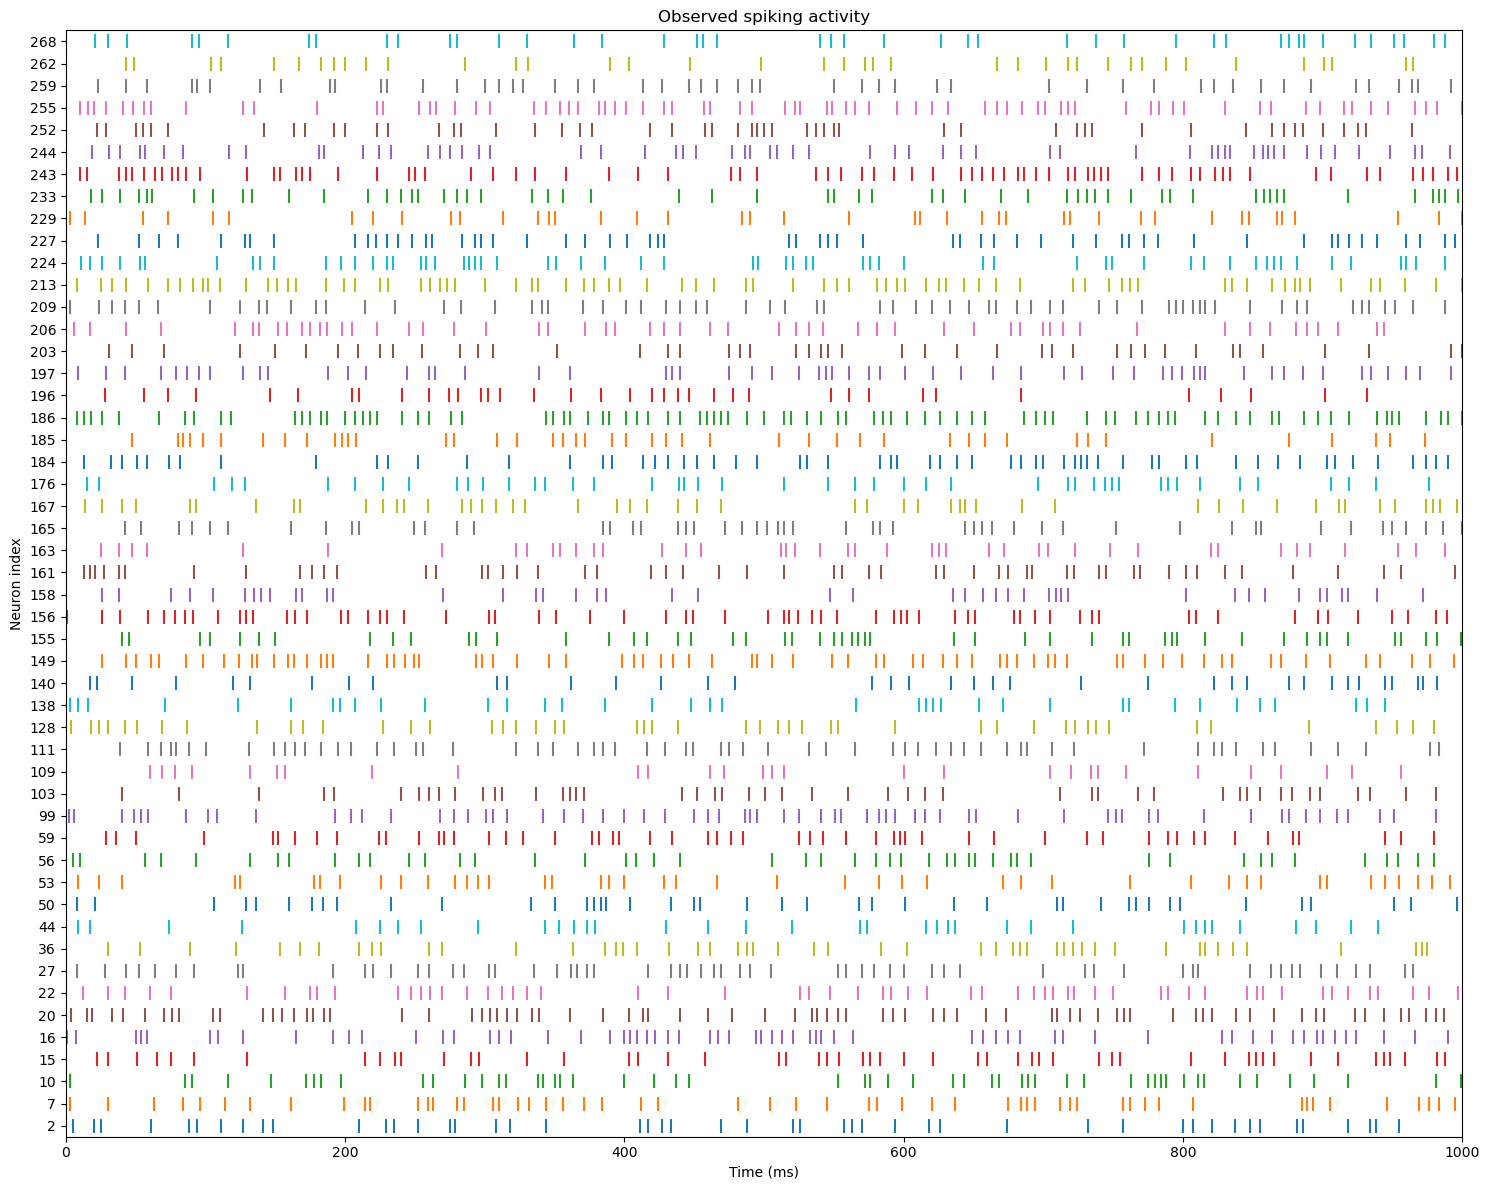

In [107]:
spikes = spike_data_dict['null']

plt.figure(figsize=(15,12))

for i in range(len(index_obs)):
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)

plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0, 1000])
plt.ylim([-0.5, n_obs - 0.5])
plt.title("Observed spiking activity")
plt.tight_layout()
plt.show()

In [116]:
G_learned = SCM_learner(spike_data_dict, 
                        node_list=list(index_obs), 
                        stimulation_protocol=stimulation_protocol, 
                        alpha = 0.01)

In [119]:
G_true = nx.subgraph(G, index_obs)

A_true = nx.adjacency_matrix(G_true).todense() 
A_learned = nx.adjacency_matrix(G_learned).todense() 
A_diff = A_true - A_learned

pd.DataFrame(A_true - A_learned)
SHD = np.sum(np.abs(A_true- A_learned))

print('total edges true = ',G_true.number_of_edges())
print('SHD = ', SHD)
print('True positives = ', np.sum( (A_true == 1)*(A_learned==1) ) )
print('True negatives = ', np.sum( (A_true == 0)*(A_learned==0)) )
print('False positives = ', np.sum(A_diff == -1) )
print('False negatives = ', np.sum(A_diff == 1) )

total edges true =  98
SHD =  195
True positives =  1
True negatives =  2304
False positives =  98
False negatives =  97


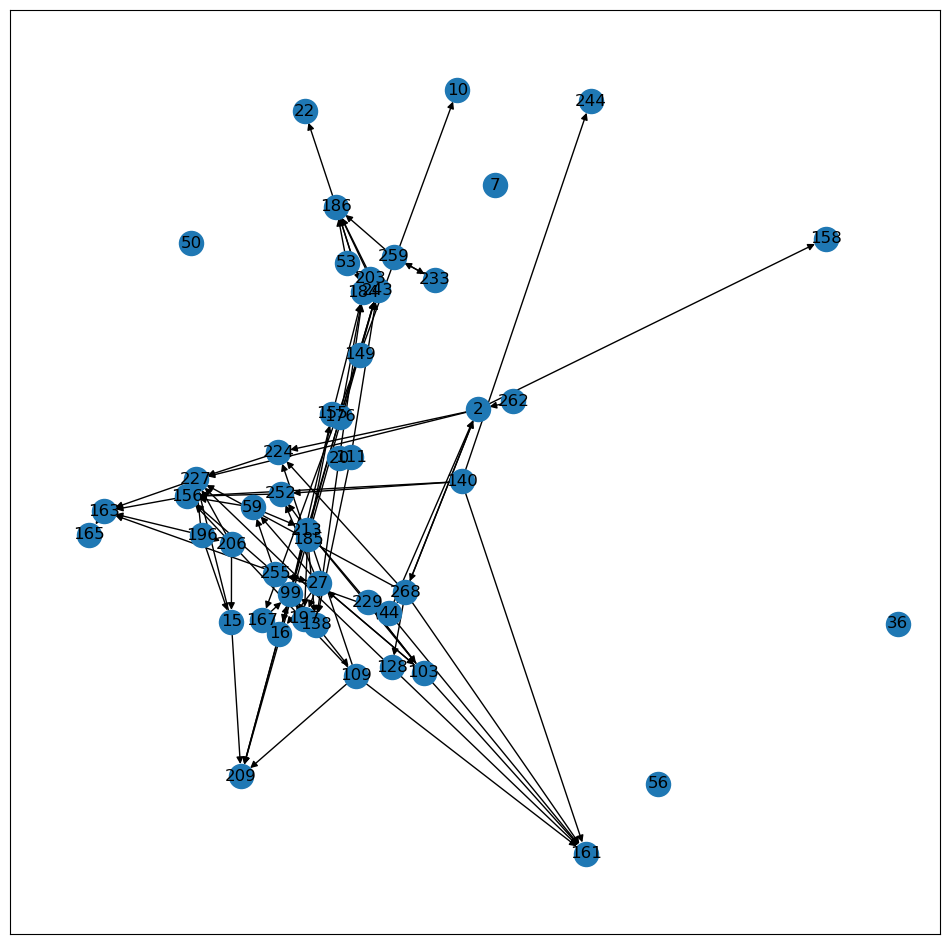

In [121]:
plt.figure(figsize=(12,12))
nx.draw_networkx(G_learned)

- plot antall FP eller FN på y-aksen som funksjon av antall celler observert
- ROC kurve 


In [69]:
spike_data = spike_data_dict
node_list=index_obs
stimulation_protocol=stimulation_protocol
alpha = 0.05

In [70]:
SCM_learned = nx.DiGraph()
SCM_learned.add_nodes_from(np.sort(node_list))

# observational data
spikes = spike_data['null']

#stimulation_protocol_str = [''.join(str(i) for i in intervention_set) for intervention_set in stimulation_protocol]

# loop through nodes in network, to test what other notes can explain spiking using a linear model
for idx, neuron_id in enumerate(node_list):

    target_spikes = spikes[idx].numpy()

    source_spikes = np.delete(torch.roll(spikes, 1), idx, axis=0) # effect from 1 time step before
    #source_spikes2 = np.delete(torch.roll(spikes, 2), idx, axis=0) # effect from 2 time step before
    autoregressive_feature1 = torch.roll(spikes[idx], 1).numpy() # 1 time step history effects
    autoregressive_feature2 = torch.roll(spikes[idx], 2).numpy() # 2 time step history effects
    autoregressive_feature3 = torch.roll(spikes[idx], 3).numpy() # 3 time step history effects

    # create design matrix
    X = np.vstack((source_spikes, autoregressive_feature1, autoregressive_feature2))

    # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
    linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
    res = linear_model.fit()

    source_nodes = np.delete(node_list, idx) # remove target neuron
    p_values = res.pvalues[1:len(node_list)] # p-values of t-test of effect from source to targat neuron (first time step coefficient)

    #print(p_values)

    for k, p in enumerate(p_values):
        if p < alpha:
            SCM_learned.add_edge(source_nodes[k], neuron_id)

# Adjacency matrix based on observational data
A_learned = nx.adjacency_matrix(SCM_learned).todense() 
SCM_observational = SCM_learned.copy()

# loop through each intervention set to remove confounding effects
for intervention_set in stimulation_protocol:
    intervention_set_str = ''.join(str(x) for x in intervention_set)        
    spikes = spike_data[intervention_set_str] # get data set where the given intervention occurred

    for intervened_neuron in intervention_set:            
        intervened_neuron_idx = node_list.index(intervened_neuron)
        print(intervened_neuron_idx)
        # get indeces of neurons that intervened node is correlated with
        target_idx = np.where(A_learned[intervened_neuron_idx, :] == 1) 
        #target_neurons = node_list[target_idx[0]]
        target_neurons = [v for _, v in SCM_observational.out_edges(intervened_neuron)]

        if len(target_neurons) == 0:
            continue

        else:
            # loop through the neurons that the intervened node is observationally correlated with
            for target_neuron in target_neurons:
                #target_neuron_idx = np.where(node_list == target_neuron)[0]
                target_neuron_idx = node_list.index(target_neuron)
                print(target_neuron_idx)

                sources_idx = np.where(A_learned[:, target_neuron_idx] == 1) # possible explanations for target neuron
                #source_neurons = index_obs[sources_idx[0]]
                source_neurons = [u for u, _ in SCM_observational.in_edges(target_neuron)]

                intervened_idx = np.where(source_neurons == intervened_neuron)[0]

                target_spikes = spikes[target_neuron_idx].numpy()

                source_spikes = torch.roll(spikes[sources_idx[0]], 1).numpy() # effect from 1 time step before
                #source_spikes2 = torch.roll(spikes[sources_idx[0]], 2).numpy() # effect from 2 time step before
                autoregressive_feature1 = torch.roll(spikes[target_neuron_idx], 1).numpy() # 1 time step history effects
                autoregressive_feature2 = torch.roll(spikes[target_neuron_idx], 2).numpy() # 2 time step history effects

                # create design matrix
                X = np.vstack((source_spikes, autoregressive_feature1, autoregressive_feature2))

                # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
                linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
                res = linear_model.fit()
                p_values = res.pvalues[intervened_idx+1] # p-values of t-test of effect from source to targat neuron (first time step coefficient)
                #
                #print('p_values = ',p_values)
                #print(res.pvalues)
                if np.any(p_values > alpha):
                    #print(f'removed edge ({intervened_neuron}, {target_neuron})')
                    SCM_learned.remove_edge(intervened_neuron, target_neuron)

0
14
[1.46714142e-73 2.63498761e-86 6.49403597e-01 1.00591645e-23
 1.79913436e-01 1.04994791e-09 9.23652541e-02 8.44405823e-01
 1.89518256e-01 1.34436404e-16 1.88100190e-14]
37
[6.72167653e-118 5.96349036e-001 1.02293993e-018 5.75385541e-001
 4.58153798e-001 5.06572255e-001 3.28690308e-001 5.74608187e-007
 5.23796799e-002 5.75545068e-001 1.14841936e-009 5.76863678e-001
 1.97621154e-012 4.21350370e-010]
62
[1.38181727e-107 2.53420673e-031 2.28183615e-014 2.20801511e-017
 2.42806291e-016 4.46602758e-008 9.93443447e-001 2.97924726e-009
 7.62509759e-010 5.07899730e-010 5.77377040e-001 1.14973960e-010
 2.33819682e-027 3.85156638e-021]
85
[4.72944200e-70 4.33726502e-01 9.71249443e-01 7.38364657e-01
 8.13292564e-01 3.79478683e-01 2.95413817e-33 1.98749190e-01
 6.74812007e-09 1.28836577e-01 1.03591392e-06 4.50686199e-06]
1
34
[1.19419168e-62 7.63434174e-01 4.73305644e-01 1.82916973e-01
 5.79659146e-18 8.61499756e-22 9.53552607e-29 1.13243621e-28
 7.39510101e-01 1.63281599e-23 5.30610210e-28 3.

KeyboardInterrupt: 

In [35]:
node_list.index(intervened_neuron)

0